In [247]:
# build graph pool with the following structure 
# graph_pool = {'graphs': {gid: { 
#                          'nodes': {nodeid: 'label'},
#                          'edges': [{'source': -1, 'target': -1}]}}}
import pandas as pd
import json
import os
import sys
import glob
import graph_tool.all as gt
from datetime import datetime
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import numpy as np
import math

statistics_dir = '/home/maniaa/ashes/code/statistics/'
stat_csv = [(statistics_dir + f) for f in listdir(statistics_dir) if (f.endswith(".csv") and isfile(join(statistics_dir, f)))]
stat_csv.sort()

In [248]:
request_data = pd.DataFrame()

for index, f in enumerate(stat_csv):
    df1 = pd.read_csv(f)
    df = df1[df1['state']=='SUCCEEDED']
    df['submit_ts'] = df['submitTime'] - df['submitTime'].min();
    df['submit_ts_15minbin'] = (df['submitTime'] - df['submitTime'].min())//(10*60*1000);
    request_data[f.split('/')[-1].split('.csv')[0]] = df.groupby('submit_ts_15minbin')['HDFS_INPUT_SIZE'].agg('sum');

    print(f, df['submit_ts_15minbin'].min(), df['submit_ts_15minbin'].max())
    
    if index == 60:
        break

request_data = request_data.fillna(request_data.mean())

stats = request_data.T.agg(['mean', 'count', 'std', 'median', 'max', 'min'])
request_data['mean'] = stats.T['mean']
request_data['count'] = stats.T['count']
request_data['std'] = stats.T['std']
request_data['median'] = stats.T['median']
request_data['max'] = stats.T['max']
request_data['min'] = stats.T['min']
request_data['ci95_hi'] = request_data['mean'] + 1.96*request_data['std']/np.sqrt(request_data['count'])
request_data['ci95_lo'] = request_data['mean'] - 1.96*request_data['std']/np.sqrt(request_data['count'])


/home/maniaa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/maniaa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


/home/maniaa/ashes/code/statistics/08-02-2018-backup.csv 0 144
/home/maniaa/ashes/code/statistics/08-02-2018.csv 0 144
/home/maniaa/ashes/code/statistics/08-03-2018.csv 0 143
/home/maniaa/ashes/code/statistics/08-04-2018.csv 0 143
/home/maniaa/ashes/code/statistics/08-05-2018.csv 0 143
/home/maniaa/ashes/code/statistics/08-06-2018.csv 0 143
/home/maniaa/ashes/code/statistics/08-07-2018.csv 0 143
/home/maniaa/ashes/code/statistics/08-08-2018.csv 0 183
/home/maniaa/ashes/code/statistics/08-09-2018.csv 0 141
/home/maniaa/ashes/code/statistics/08-10-2018.csv 0 142
/home/maniaa/ashes/code/statistics/08-11-2018.csv 0 143
/home/maniaa/ashes/code/statistics/08-12-2018.csv 0 143
/home/maniaa/ashes/code/statistics/08-13-2018.csv 0 146
/home/maniaa/ashes/code/statistics/08-14-2018.csv 0 172
/home/maniaa/ashes/code/statistics/08-15-2018.csv 0 144
/home/maniaa/ashes/code/statistics/08-16-2018.csv 0 143
/home/maniaa/ashes/code/statistics/08-17-2018.csv 0 143
/home/maniaa/ashes/code/statistics/08-18-

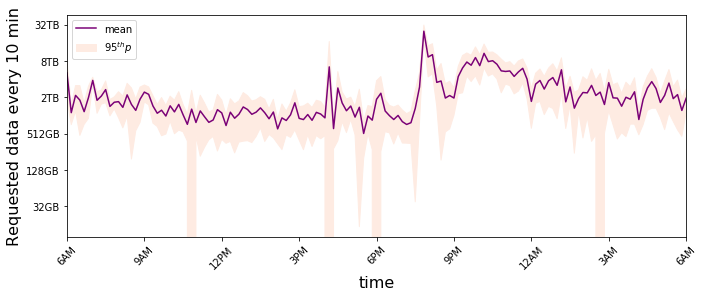

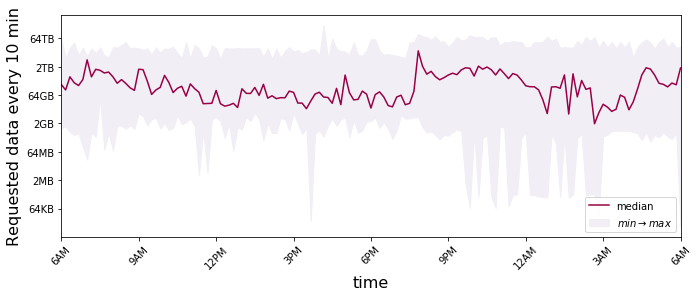

In [246]:
from matplotlib.pyplot import *

def log_2_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    val = math.log(x, 2)
    
    if val >= 10 and val < 20: 
        return str(int(2**(val - 10))) + 'KB'
    elif val >= 20 and val < 30: 
        return str(int(2**(val - 20))) + 'MB'
    elif val >= 30 and val < 40: 
        return str(int(2**(val - 30))) + 'GB'
    elif val >= 40 and val < 50: 
        return str(int(2**(val - 40))) + 'TB'
    elif val >= 50 and val < 60: 
        return str(int(2**(val - 50))) + 'PB'
    return '%d' % (x)

def format_xticks10min(x, pos=None):
    hour = (int(x)*600)//3600
    daytime = ''
    if 0 <= hour and hour < 6:
        daytime = 'AM'
        hour += 6;
    elif hour == 6:
        daytime = 'PM'
        hour += 6;
    elif 6 < hour and hour < 18:
        daytime = 'PM'
        hour -= 6;
    elif hour == 18:
        daytime = 'AM'
        hour -= 6;
    elif 18 < hour and hour <= 24:
        daytime = 'AM'
        hour -= 18;
    return str(hour) + daytime

fig, ax = plt.subplots(figsize=(10,4))
request_data['mean'].plot(ax=ax, color='#7a0177', label='mean')
ax.fill_between(request_data.index, 
                (request_data['mean'] + request_data['ci95_lo'].values, 
                (request_data['mean'] - request_data['ci95_hi']).values, color='#feebe2', 
                label=r'${95}^{th}p$')
#ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticks))
ax.set_yscale('log', basey=2)
formatter = FuncFormatter(log_2_product)
ax.yaxis.set_major_formatter(formatter)
plt.xticks(np.arange(0, 146, 18), rotation=45)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks10min))
plt.xlabel("time", fontsize=16)
plt.ylabel("Requested data every 10 min", fontsize=16)
ax.legend(loc='upper left')

plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
fig.savefig('/home/maniaa/ashes/drawings/fig_requesteddatasize_mean95.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_requesteddatasize_mean95.png', format='png', dpi=200)
plt.show()


fig, ax = plt.subplots(figsize=(10,4))
request_data['median'].plot(ax=ax, color='#980043', label='median')
ax.fill_between(request_data.index, (request_data['min']).values, 
                (request_data['max']).values, color='#f1eef6', label=r'$min \rightarrow max$')
#ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticks))
ax.set_yscale('log', basey=2)
formatter = FuncFormatter(log_2_product)
ax.yaxis.set_major_formatter(formatter)
plt.xticks(np.arange(0, 146, 18), rotation=45)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks10min))
plt.xlabel("time", fontsize=16)
plt.ylabel("Requested data every 10 min", fontsize=16)
ax.legend(loc='lower right')

plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
fig.savefig('/home/maniaa/ashes/drawings/fig_requesteddatasize_median_maxmin.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_requesteddatasize_median_maxmin.png', format='png', dpi=200)
plt.show()